# Project: Predicting Peak NBA Player Performance

**Objective:**  
To quantitatively predict an NBA player's peak per-game statistics using early-career data, enabling forward-looking evaluations of player potential.

---

### Model Overview

- **Target Variables:**  
  Traditional per-game stats — minutes, points, rebounds, assists, steals, blocks — from a player's peak season, identified via Player Efficiency Rating (PER).

- **PER:**  
  A widely accepted metric that summarizes a player's statistical production into a single per-minute number
  
- **Feature Set:**  
  Early-career traditional statistics serve as predictors. Only seasons with significant minutes are included to mitigate PER outliers and ensure meaningful comparisons.

- **Peak Season Identification:**  
  PER is used to locate each player's statistical peak. While PER favors offensive production and may undervalue defensive specialists, it provides a consistent baseline for peak detection.

- **Model Framing:**  
  The model learns from historical player trajectories to forecast peak output, offering a data-driven lens into player development and potential.

---

### Limitations & Future Enhancements

- **Beyond Box Score:**  
  Traditional stats may not fully capture a player's impact. Future iterations could predict "win contribution" or team success metrics.

- **Non-Linear Progression:**  
  Career arcs are influenced by trades, coaching changes, role shifts, and opportunity — factors not currently modeled.

- **Injury & Contextual Factors:**  
  Injuries, teammate quality, coaching, and team environment can skew statistical output. These contextual variables are candidates for future inclusion.

- **Era Normalization:**  
  To account for rule changes and pace shifts, relative statistics (e.g., player stats vs. league averages) could be engineered for fairer comparisons across eras.

## Data preparation

### Library Installation

In [7]:
import pandas as pd
import numpy as np
import math

### Error handling function

In [8]:
def weighted_mean_ignore_nan(values, weights):
    vals = pd.to_numeric(values, errors="coerce")
    wts = pd.to_numeric(weights, errors="coerce").fillna(0)
    mask = ~vals.isna() & (wts > 0)
    if not mask.any():
        return np.nan
    return np.sum(vals[mask] * wts[mask]) / np.sum(wts[mask])

### Data Ingestion

To ensure consistency and relevance in modeling, all player seasons prior to 1980 are excluded from the dataset. This cutoff reflects several key shifts in NBA history:

- Defensive statistics such as steals and blocks were not officially recorded until the 1973–74 season.
- The three-point line was introduced in the 1979–80 season, fundamentally altering offensive dynamics.
- The 1980s marked a transformative era of league growth, catalyzed by the Bird–Magic rivalry and increased media attention.

Given these structural changes, the 1980s are treated as the beginning of the "Modern NBA." Restricting the dataset to players who debuted in 1980 or later ensures that feature data reflects a more standardized and predictive environment for estimating peak performance.

In [9]:
min_games = 30
cutoff_year = 1980
number_of_seasons = 3

### Feature and Target Engineering

This section outlines the construction of input features and target variables for model training:

- **Target Variables:**  
  Per-game statistics from each player's peak season — including minutes, points, rebounds, assists, steals, and blocks — are extracted as prediction targets.

- **Feature Set:**  
  Traditional per-game statistics from a player's initial seasons are used as input features. These reflect early-career performance and form the basis for forecasting peak output.

- **No Feature Scaling Applied:**  
  Since the model is built using XGBoost, which relies on decision trees, feature scaling is unnecessary. Tree-based models are invariant to feature magnitude, and preserving the original data ranges enhances interpretability of predictions.

- **Code Modularity:**  
  Reusable functions are implemented to streamline repeatable tasks and improve maintainability. Key parameters — such as the cutoff year, minimum games played per season, and number of initial seasons used — are configurable, allowing users to easily adapt the pipeline to different cohort definitions or modeling scenarios.

In [10]:
def build_early_season_features(
    per_game_stats,
    first_season_map,
    debut_season,
    stat_cols,
    min_games,
    number_of_seasons
):
    """
    Build early-season feature matrix for a given debut cohort.
    """
    debutants = first_season_map[first_season_map == debut_season].index
    debutant_stats = per_game_stats[
        (per_game_stats["season"] >= debut_season) &
        (per_game_stats["player_id"].isin(debutants))
    ].copy().sort_values(["player_id", "season"]).reset_index(drop=True)

    grouped = debutant_stats.groupby(["player", "player_id", "season"], sort=False)
    grouped_stats_only = grouped[stat_cols + ["g"]]  # include 'g' for weighting

    weighted_stats = grouped_stats_only.apply(
        lambda df: pd.Series({
            col: weighted_mean_ignore_nan(df[col], df["g"]) for col in stat_cols
        } | {
            "total_games": pd.to_numeric(df["g"], errors="coerce").fillna(0).max()
        })
    ).reset_index().sort_values(["player_id", "season"]).reset_index(drop=True)

    eligible_seasons = weighted_stats[weighted_stats["total_games"] >= min_games].copy()
    season_counts = eligible_seasons["player_id"].value_counts()
    eligible_players = season_counts[season_counts >= number_of_seasons].index

    first_seasons = (
        eligible_seasons[eligible_seasons["player_id"].isin(eligible_players)]
        .sort_values(["player_id", "season"])
        .groupby("player_id", sort=False)
        .head(number_of_seasons)
        .copy()
    )
    first_seasons["season_index"] = first_seasons.groupby("player_id").cumcount()

    selected_columns = ["player", "player_id", "season", "season_index"] + stat_cols + ["total_games"]
    sorted_stats = first_seasons[selected_columns].sort_values(
        ["player_id", "season_index"]
    ).reset_index(drop=True)

    pivoted = (
        sorted_stats
        .set_index(["player_id", "player", "season_index"])
        .unstack("season_index")
    )
    pivoted.columns = [f"{stat}_season{season}" for stat, season in pivoted.columns]
    early_season_df = pivoted.reset_index()

    early_season_df = early_season_df.drop(
        columns=[col for col in early_season_df.columns if col.startswith("season_") or col.startswith("total_games_")]
    )

    return early_season_df

In [11]:
def build_training_features(per_game_stats, advanced_stats, stat_cols, min_games, number_of_seasons):
    """
    Build training features (X_df, Y_df) by combining early-season stats with peak PER outcomes.
    """
    first_season_per_player = per_game_stats.groupby("player_id")["season"].min()
    pre2010_players = first_season_per_player[first_season_per_player < cutoff_year].index

    filtered_game_stats = per_game_stats[
        (per_game_stats["season"] >= cutoff_year) &
        (~per_game_stats["player_id"].isin(pre2010_players))
    ].copy()

    for c in stat_cols:
        if c in filtered_game_stats.columns:
            filtered_game_stats[c] = pd.to_numeric(filtered_game_stats[c], errors="coerce")

    filtered_game_stats = filtered_game_stats.sort_values(["player_id", "season"]).reset_index(drop=True)

    grouped = filtered_game_stats.groupby(["player", "player_id", "season"], sort=False)
    grouped_stats_only = grouped[stat_cols + ["g"]] 

    weighted_stats = grouped_stats_only.apply(
        lambda df: pd.Series({
            col: weighted_mean_ignore_nan(df[col], df["g"]) for col in stat_cols
        } | {
            "total_games": pd.to_numeric(df["g"], errors="coerce").fillna(0).max()
        })
    ).reset_index().sort_values(["player_id", "season"]).reset_index(drop=True)

    # --- Eligibility filtering ---
    eligible_seasons = weighted_stats[weighted_stats["total_games"] >= min_games].copy()
    season_counts = eligible_seasons["player_id"].value_counts()
    eligible_players = season_counts[season_counts >= number_of_seasons].index

    first_seasons = (
        eligible_seasons[eligible_seasons["player_id"].isin(eligible_players)]
        .sort_values(["player_id", "season"])
        .groupby("player_id", sort=False)
        .head(number_of_seasons)
        .copy()
    )
    first_seasons["season_index"] = first_seasons.groupby("player_id").cumcount()

    selected_columns = ["player", "player_id", "season", "season_index"] + stat_cols + ["total_games"]
    sorted_stats = first_seasons[selected_columns].sort_values(
        ["player_id", "season_index"]
    ).reset_index(drop=True)

    pivoted = (
        sorted_stats
        .set_index(["player_id", "player", "season_index"])
        .unstack("season_index")
    )
    pivoted.columns = [f"{stat}_season{season}" for stat, season in pivoted.columns]
    early_season_df = pivoted.reset_index()

    early_season_df = early_season_df.drop(
        columns=[col for col in early_season_df.columns if col.startswith("season_") or col.startswith("total_games_")]
    )

    relevant_advanced_stats = advanced_stats[
        (advanced_stats['g'] > min_games) &
        (advanced_stats['mp'] > 800) &
        (advanced_stats['season'] >= cutoff_year)
    ]

    peak_per_indices = relevant_advanced_stats.groupby('player')['per'].idxmax()
    peak_per_rows = relevant_advanced_stats.loc[peak_per_indices]
    average_peak_age = math.ceil(peak_per_rows['age'].mean())

    eligible_players_df = relevant_advanced_stats[relevant_advanced_stats['age'] >= average_peak_age]
    filtered = relevant_advanced_stats[
        relevant_advanced_stats['player'].isin(eligible_players_df['player'])
    ]

    peak_idx = filtered.groupby('player')['per'].idxmax()
    peak_rows = filtered.loc[peak_idx, ['player', 'season', 'per', 'age']]
    peak_rows = peak_rows.rename(columns={
        'season': 'peak_season',
        'per': 'peak_per',
        'age': 'age_at_peak'
    })

    peak_with_stats = (
        peak_rows
        .merge(weighted_stats,
               left_on=['player', 'peak_season'],
               right_on=['player', 'season'],
               how='left')
    )

    peak_cols = stat_cols
    cols_to_keep = ['player_id', 'player'] + peak_cols
    peak_with_stats = peak_with_stats[cols_to_keep]

    rename_map = {col: f"{col}_peak" for col in peak_cols}
    peak_with_stats = peak_with_stats.rename(columns=rename_map)

    merged_df = early_season_df.merge(
        peak_with_stats,
        on=["player_id", "player"],
        how="inner"
    ).dropna().reset_index(drop=True)

    peak_cols = [col for col in merged_df.columns if col.endswith("_peak")]
    X_df = merged_df.drop(columns=peak_cols + ["player_id", "player"])
    Y_df = merged_df[peak_cols].copy()

    return X_df, Y_df

In [12]:
def build_inference_features(per_game_stats, debut_season, stat_cols, min_games, number_of_seasons):
    """
    Build inference features for a given debut cohort.
    Produces the same wide-format feature matrix as build_training_features,
    but without peak labels.
    """
    first_season_map = per_game_stats.groupby("player_id")["season"].min()

    return build_early_season_features(
        per_game_stats=per_game_stats,
        first_season_map=first_season_map,
        debut_season=debut_season,
        stat_cols=stat_cols,
        min_games=min_games,
        number_of_seasons=number_of_seasons
    )

## Model Training Data

In [13]:
stat_cols_all = [
    "mp_per_game", "pts_per_game", "trb_per_game",
    "ast_per_game", "stl_per_game", "blk_per_game"
]

per_game_stats = pd.read_csv('Player Per Game.csv')
advanced_stats = pd.read_csv('Advanced.csv')
X_df, Y_df = build_training_features(
    per_game_stats=per_game_stats,
    advanced_stats=advanced_stats,
    stat_cols=stat_cols_all,
    min_games=min_games,
    number_of_seasons = number_of_seasons
)

print("Training features (X_df) shape:", X_df.shape)
print("Training targets (Y_df) shape:", Y_df.shape)
print(X_df.head())
print(Y_df.head())

Training features (X_df) shape: (1246, 18)
Training targets (Y_df) shape: (1246, 6)
   mp_per_game_season0  mp_per_game_season1  mp_per_game_season2  \
0            22.500000                 19.0                 33.5   
1            35.000000                 36.0                 40.4   
2            14.600000                 10.2                 21.1   
3            13.405556                 18.9                 14.8   
4            20.700000                 33.9                 36.2   

   pts_per_game_season0  pts_per_game_season1  pts_per_game_season2  \
0                  14.1                  10.3                  19.2   
1                  18.7                  22.3                  23.0   
2                   3.6                   2.2                   4.5   
3                   2.7                   5.9                   5.2   
4                   7.2                  13.9                  18.5   

   trb_per_game_season0  trb_per_game_season1  trb_per_game_season2  \
0        

## Multi-Target XGBoost with SHAP Model Definition

This function performs hyperparameter tuning, evaluation, and interpretation for a multi-target regression model using XGBoost. It is designed to predict multiple continuous outputs (e.g., player statistics) simultaneously and provide per-target insights via SHAP.

### Function: `tune_xgb_multioutput_with_shap`

**Purpose:**  
- Tune an `XGBRegressor` wrapped in `MultiOutputRegressor` using randomized search on a proxy target  
- Evaluate model performance using RMSE and R² for each target variable  
- Generate SHAP summary plots to interpret feature importance per target

**Inputs:**
- `X`: Feature matrix (e.g., early-career player statistics)
- `Y`: Target matrix (e.g., peak-season statistics)
- `param_grid`: Dictionary of hyperparameter ranges for randomized search
- `n_iter`: Number of iterations for randomized search (default: 50)
- `test_size`: Proportion of data used for testing (default: 0.2)
- `random_state`: Seed for reproducibility (default: 42)
- `cv`: Number of cross-validation folds (default: 5)

**Workflow:**
1. **Train/Test Split:**  
   Data is split into training and testing sets using `train_test_split`.

2. **Hyperparameter Tuning:**  
   A randomized search is performed on the first target column to identify optimal parameters for the base `XGBRegressor`.

3. **Model Fitting:**  
   The best parameters are used to fit a `MultiOutputRegressor` across all targets.

4. **Evaluation:**  
   RMSE and R² are computed for each target variable and printed in sorted order.

5. **Interpretability with SHAP:**  
   SHAP summary plots are generated for each target to visualize feature contributions.

**Outputs:**
- `tuned_model`: Fitted multi-output XGBoost model
- `best_params`: Best hyperparameters from randomized search
- `rmse_df`: DataFrame of RMSE scores per target
- `r2_df`: DataFrame of R² scores per target

In [14]:
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import root_mean_squared_error, r2_score


def tune_xgb_multioutput_with_shap(X, Y, param_grid, n_iter=50, test_size=0.2, random_state=42, cv=5):
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=test_size, random_state=random_state
    )
    
    base_model = XGBRegressor(objective="reg:squarederror", random_state=random_state)
    
    xgbr = XGBRegressor(objective="reg:squarederror", random_state=random_state)
    random_search = RandomizedSearchCV(
        estimator=xgbr,
        param_distributions=param_grid,
        n_iter=n_iter,
        scoring="neg_root_mean_squared_error",
        cv=cv,
        verbose=1,
        n_jobs=-1,
        random_state=random_state
    )
    random_search.fit(X_train, y_train.iloc[:, 0])
    
    best_params = random_search.best_params_
    print("Best parameters:", best_params)
    print(f"Best CV RMSE (proxy target): {-random_search.best_score_:.4f}")
    
    tuned_model = MultiOutputRegressor(
        XGBRegressor(**best_params, objective="reg:squarederror", random_state=random_state)
    )
    tuned_model.fit(X_train, y_train)
    
    y_pred = tuned_model.predict(X_test)
    
    rmse_per_target, r2_per_target = {}, {}
    for i, col in enumerate(y_test.columns):
        rmse = root_mean_squared_error(y_test.iloc[:, i], y_pred[:, i])
        r2 = r2_score(y_test.iloc[:, i], y_pred[:, i])
        rmse_per_target[col] = rmse
        r2_per_target[col] = r2
    
    rmse_df = pd.DataFrame.from_dict(rmse_per_target, orient="index", columns=["RMSE"])
    r2_df = pd.DataFrame.from_dict(r2_per_target, orient="index", columns=["R2"])
    
    print("\nPer-target RMSE:")
    print(rmse_df.sort_values("RMSE"))
    print("\nPer-target R²:")
    print(r2_df.sort_values("R2", ascending=False))
    
    for i, col in enumerate(y_test.columns):
        print(f"\nGenerating SHAP summary for target: {col}")
        model_i = tuned_model.estimators_[i]  
        explainer = shap.Explainer(model_i, X_train)
        shap_values = explainer(X_test)
        
        shap.summary_plot(shap_values, X_test, show=True)
        
        # Optional: dependence plot for top feature
        #top_feature = np.argsort(np.abs(shap_values.values).mean(0))[-1]
        #shap.dependence_plot(top_feature, shap_values.values, X_test)
    
    return tuned_model, best_params, rmse_df, r2_df

## Model Training

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters: {'subsample': 0.6, 'reg_lambda': 2, 'reg_alpha': 0.1, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
Best CV RMSE (proxy target): 5.3206

Per-target RMSE:
                       RMSE
stl_per_game_peak  0.219419
blk_per_game_peak  0.275681
ast_per_game_peak  0.972613
trb_per_game_peak  1.217097
pts_per_game_peak  3.400265
mp_per_game_peak   4.688948

Per-target R²:
                         R2
trb_per_game_peak  0.806680
stl_per_game_peak  0.790160
ast_per_game_peak  0.779261
blk_per_game_peak  0.771635
pts_per_game_peak  0.701337
mp_per_game_peak   0.610095

Generating SHAP summary for target: mp_per_game_peak


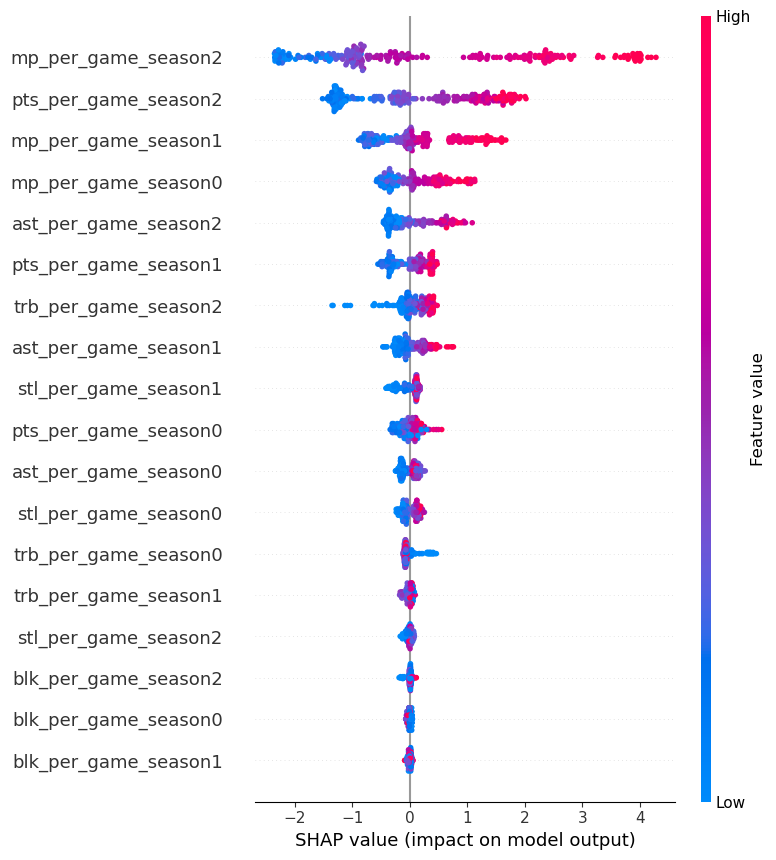


Generating SHAP summary for target: pts_per_game_peak


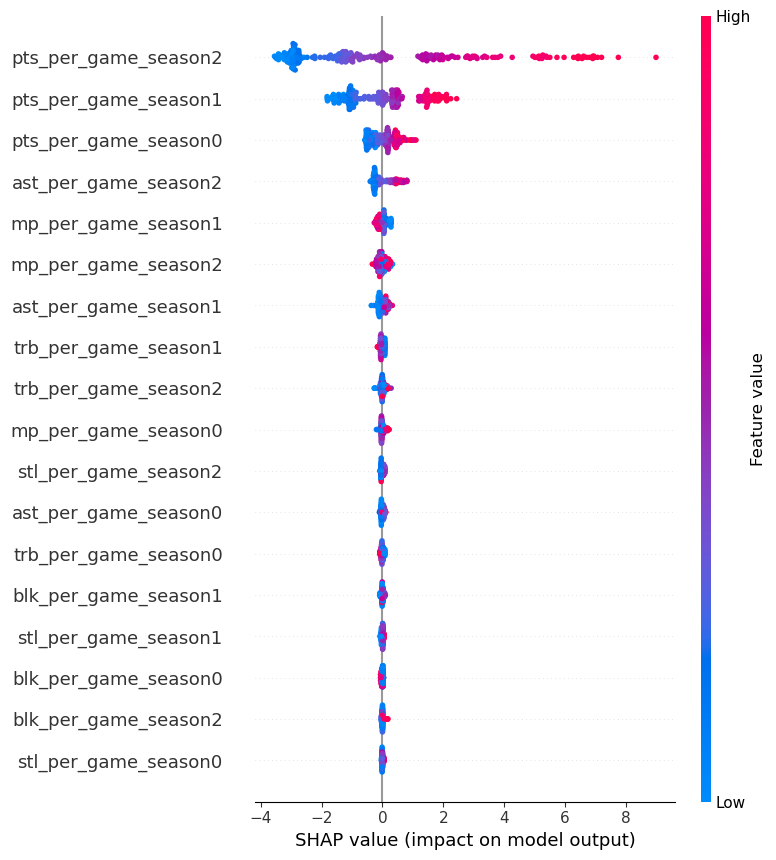


Generating SHAP summary for target: trb_per_game_peak


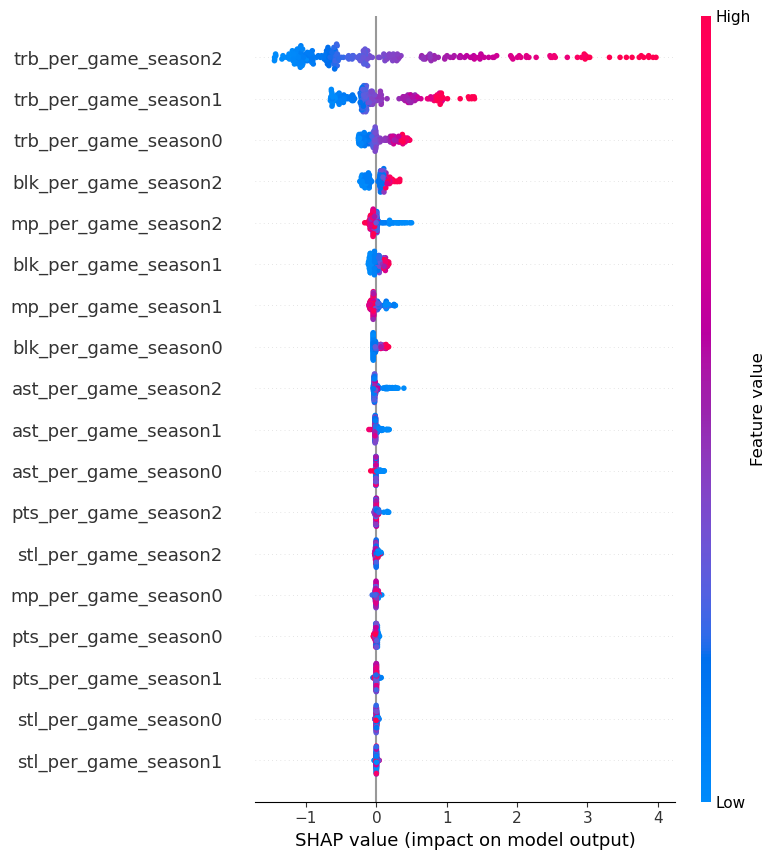


Generating SHAP summary for target: ast_per_game_peak


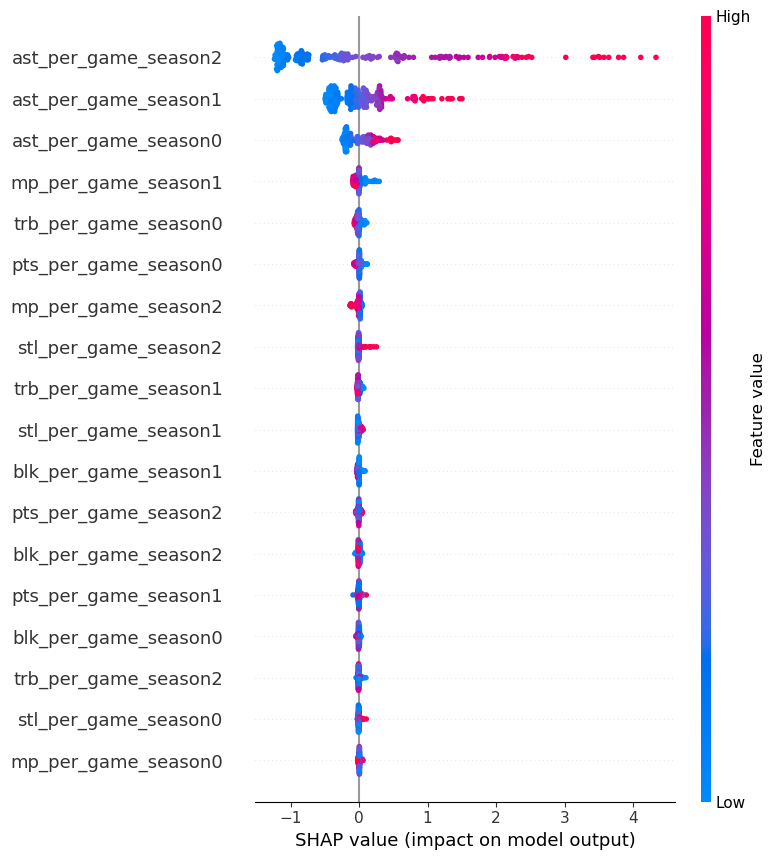


Generating SHAP summary for target: stl_per_game_peak


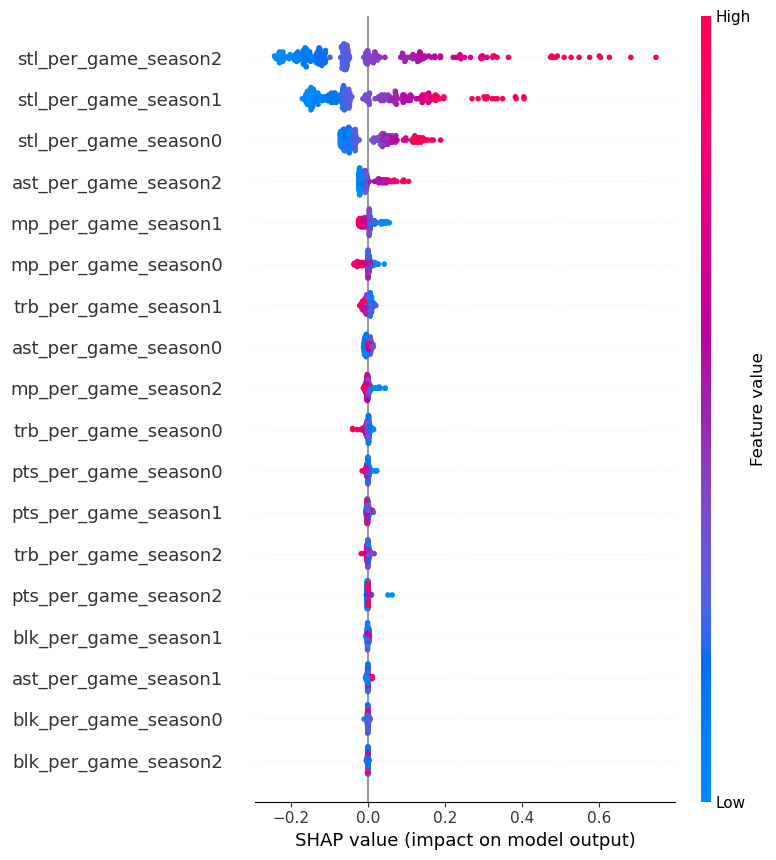


Generating SHAP summary for target: blk_per_game_peak


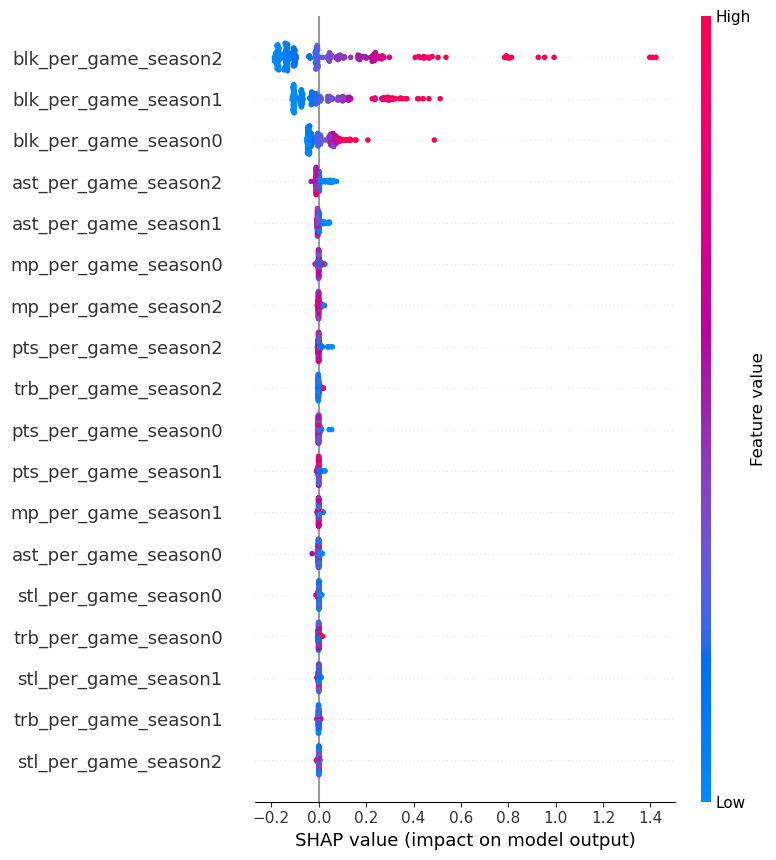

In [15]:
param_grid = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [3, 5, 7, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "reg_alpha": [0, 0.1, 0.5, 1],
    "reg_lambda": [0.5, 1, 2],
}
best_model, best_params, rmse_df, r2_df = tune_xgb_multioutput_with_shap(X_df, Y_df, param_grid)

## Inference Input Data Preparation

In [16]:
rookie_features = build_inference_features(
    per_game_stats=per_game_stats,
    debut_season=2023,
    stat_cols=stat_cols_all,
    min_games=min_games,
    number_of_seasons=number_of_seasons
)

print("Rookie features shape:", rookie_features.shape)
print(rookie_features.head())

Rookie features shape: (29, 20)
   player_id            player  mp_per_game_season0  mp_per_game_season1  \
0  agbajoc01      Ochai Agbaji                 20.5               21.025   
1  banchpa01    Paolo Banchero                 33.8               35.000   
2  beaucma01  MarJon Beauchamp                 13.5               12.700   
3  branhma01    Malaki Branham                 23.5               21.300   
4  braunch01   Christian Braun                 15.5               20.200   

   mp_per_game_season2  pts_per_game_season0  pts_per_game_season1  \
0                27.20                   7.9                 5.825   
1                34.40                  20.0                22.600   
2                 4.48                   5.1                 4.400   
3                 9.10                  10.2                 9.200   
4                33.90                   4.7                 7.300   

   pts_per_game_season2  trb_per_game_season0  trb_per_game_season1  \
0             10.40

## Model Inference

This section applies the trained multi-target regression model to a new cohort of players, generating predictions for their potential peak-season statistics.

### Workflow Steps:

1. **Extract Player Identifiers:**  
   Separate `player_id` and `player` name columns from the feature set to preserve metadata for later use.

2. **Align Feature Columns:**  
   Drop identifier columns and reindex the rookie feature matrix to match the training feature schema (`X_df.columns`). Missing columns are filled with zeros to ensure compatibility.

3. **Generate Predictions:**  
   Use the trained model (`best_model`) to predict peak per-game statistics for each rookie.

4. **Format Predictions:**  
   Wrap the output in a `DataFrame` using the same target column names (`Y_df.columns`) and preserve row indexing.

5. **Reattach Identifiers:**  
   Concatenate player identifiers with the prediction results to produce a final, interpretable output.

### Output:
- `results`: A DataFrame containing each rookie's identifier alongside their predicted peak-season statistics.

This modular approach ensures clean separation of metadata, schema alignment, and reproducible prediction logic. It can be easily extended to other cohorts or integrated into a larger pipeline.

In [17]:
rookie_ids = rookie_features[["player_id", "player"]].copy()

rookie_X = rookie_features.drop(columns=["player_id", "player"], errors="ignore")
rookie_X = rookie_X.reindex(columns=X_df.columns, fill_value=0)

rookie_preds = best_model.predict(rookie_X)

rookie_pred_df = pd.DataFrame(rookie_preds, columns=Y_df.columns, index=rookie_X.index)

results = pd.concat([rookie_ids, rookie_pred_df], axis=1)

results

,player_id,player,mp_per_game_peak,pts_per_game_peak,trb_per_game_peak,ast_per_game_peak,stl_per_game_peak,blk_per_game_peak
0,agbajoc01,Ochai Agbaji,25.096325,10.796949,4.151597,1.505327,0.821248,0.518630
1,banchpa01,Paolo Banchero,35.323452,26.587416,7.623637,5.355393,0.928227,0.608120
2,beaucma01,MarJon Beauchamp,21.105934,8.044459,3.085650,1.074790,0.520847,0.268770
3,branhma01,Malaki Branham,23.758457,11.445392,2.631162,2.212216,0.555064,0.174312
4,braunch01,Christian Braun,30.681189,15.790189,5.083771,2.327683,0.946347,0.439394
5,chrisma02,Max Christie,24.049484,10.095181,3.649874,1.826148,0.768649,0.423523
6,daniedy01,Dyson Daniels,31.256529,15.104819,5.484622,4.817852,1.957556,0.519272
7,diengou01,Ousmane Dieng,20.379938,7.901525,3.058294,1.276149,0.603353,0.260998
8,durenja01,Jalen Duren,28.658525,13.768718,10.134719,2.730673,0.779996,0.908271
9,fontesi01,Simone Fontecchio,21.977383,10.169195,3.541283,1.443455,0.622938,0.318186
